<strong><em>Student Academic Performance Prediction:</em></strong><br>
***
This notebook attempts to study some of the factors affecting student academic success, the first measurement of success being the GPA and the second being eligibility for application of a master's degree

Features being studied are:<br>
<tab>    -> SAT score <br>
<tab>    -> Athletism<br>
<tab>    -> High School Size<br>
<tab>    -> High School Rank<br>
<tab>    -> High School Percentile<br>
<tab>    -> Gender<br>

In [311]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import Ridge , LogisticRegression, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from scipy import stats


In [312]:
merged_df= pd.read_csv('GPA2.csv')

In [313]:
success =[]
successCount = 0;
failCount = 0;
for i in merged_df["gpa"]:
    if(i >= (3)):
        success.append(True)
        successCount+= 1
    else:
        success.append(False)
        failCount+=1

merged_df.insert(7,"Success", success);
print("Succes Count is: ", successCount)
print("Fail Count is: ", failCount)

Succes Count is:  1300
Fail Count is:  2835


In [314]:
merged_df

,gpa,SAT,athlete,hsize,hsrank,hsperc,female,Success
0,2.04,920,1,10,4,40.000000,1,False
1,4.00,1170,0,940,191,20.319150,0,True
2,1.78,810,1,119,42,35.294120,0,False
3,2.42,940,0,571,252,44.133100,0,False
4,2.61,1180,0,214,86,40.186920,0,False
...,...,...,...,...,...,...,...,...
4130,2.24,990,0,233,89,38.197430,1,False
4131,2.46,900,0,10,2,20.000000,1,False
4132,4.00,1340,0,45,1,2.222222,0,True
4133,2.83,980,0,35,23,65.714290,1,False


In [315]:
merged_df.describe()

,gpa,SAT,athlete,hsize,hsrank,hsperc,female
count,4135.000000,4135.000000,4135.000000,4135.000000,4135.000000,4135.000000,4135.000000
mean,2.653969,1030.324063,0.046917,279.882709,52.777993,19.229207,0.449819
std,0.656204,139.422201,0.211486,173.576713,64.636182,16.568810,0.497536
min,0.210000,470.000000,0.000000,3.000000,1.000000,0.166667,0.000000
25%,2.210000,940.000000,0.000000,164.500000,11.000000,6.430659,0.000000
50%,2.660000,1030.000000,0.000000,251.000000,30.000000,14.583330,0.000000
75%,3.120000,1120.000000,0.000000,368.000000,70.000000,27.681105,1.000000
max,4.000000,1540.000000,1.000000,940.000000,634.000000,92.000000,1.000000


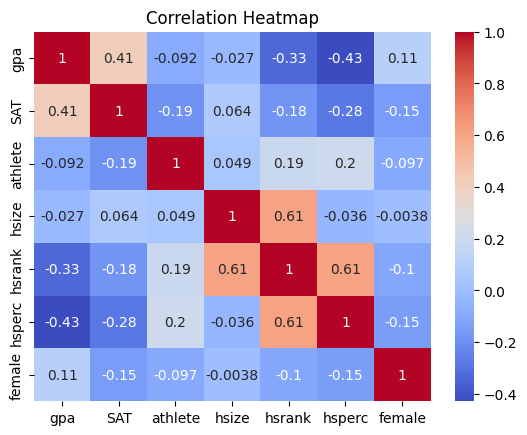

In [316]:
# Generate the correlation matrix
correlation_matrix = merged_df[['gpa', 'SAT', 'athlete','hsize','hsrank','hsperc','female']].corr()

# Generate a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [317]:
# Split data
X = merged_df[['SAT', 'athlete','hsize','hsrank','hsperc','female']]
y = merged_df['gpa']

In [318]:
best_mse = 10
best_model = 0


kf = KFold(n_splits=3, random_state=None)
total_test_mse = 0
total_train_mse = 0
    
for j, (train_index, test_index) in enumerate(kf.split(X)):

    # Train Test split
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]


    # Normalization
    mean_X_train = np.mean(X_train, axis=0)
    std_X_train = np.std(X_train, axis=0)
    mean_y_train = np.mean(y_train)
    std_y_train = np.std(y_train)


    X_train_norm = (X_train - mean_X_train)/std_X_train
    X_test_norm = (X_test - mean_X_train)/std_X_train

    y_train_norm = (y_train - mean_y_train)/std_y_train
    y_test_norm = (y_test - mean_y_train)/std_y_train

    # Linear Regression
    model = LinearRegression()
    model.fit(X_train_norm, y_train_norm)

    # Train and test MSE
    y_train_predict_unnormalized = (model.predict(X_train_norm) * std_y_train) + mean_y_train
    y_test_predict_unnormalized = (model.predict(X_test_norm) * std_y_train) + mean_y_train

    train_mse = np.mean((y_train_predict_unnormalized - y_train) ** 2)
    test_mse = np.mean((y_test_predict_unnormalized - y_test) ** 2)
    total_train_mse += train_mse
    total_test_mse += test_mse

    if (test_mse < best_mse):
        best_mse = test_mse
        best_model = model

print("Average Train MSE:", total_train_mse / kf.get_n_splits())
print("Average Test MSE:", total_test_mse / kf.get_n_splits())


Average Train MSE: 0.3015585052148853
Average Test MSE: 0.308313997568561


In [319]:
X_all_norm = (X - mean_X_train)/std_X_train
y_pred_all = best_model.predict(X_all_norm)
y_pred_all_unnormalized = (y_pred_all * std_y_train) + mean_y_train

print ("The r2 score is: ", r2_score(y,y_pred_all_unnormalized))

The r2 score is:  0.2950675173791948


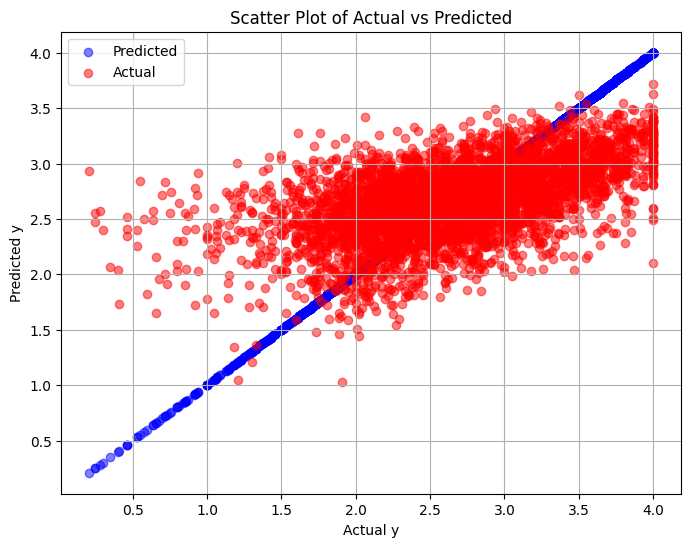

In [320]:
import matplotlib.pyplot as plt

numss = [np.random.randint(1,len(y)) for _ in range(500)]
y_rand = y[numss]
y_pred_rand = y_pred_all_unnormalized[numss]

# Assuming y_pred_all_unnormalized and y are numpy arrays of the same length
plt.figure(figsize=(8, 6))
plt.scatter(y, y, color='blue', label='Predicted', alpha=0.5)
plt.scatter(y, y_pred_all_unnormalized, color='red', label='Actual', alpha=0.5)  # Actual values
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Scatter Plot of Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()


In [321]:
best_mse = 10
best_model = 0

alphas = [0, 0.1,0.5, 1,10,100]

for i, alpha in enumerate(alphas):

    kf = KFold(n_splits=3, random_state=None)
    total_test_mse = 0
    total_train_mse = 0
        
    for j, (train_index, test_index) in enumerate(kf.split(X)):

        # Train Test split
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]


        # Normalization
        mean_X_train = np.mean(X_train, axis=0)
        std_X_train = np.std(X_train, axis=0)
        mean_y_train = np.mean(y_train)
        std_y_train = np.std(y_train)


        X_train_norm = (X_train - mean_X_train)/std_X_train
        X_test_norm = (X_test - mean_X_train)/std_X_train

        y_train_norm = (y_train - mean_y_train)/std_y_train
        y_test_norm = (y_test - mean_y_train)/std_y_train

        # Ridge Regression
        model = Ridge(alpha = alpha)
        model.fit(X_train_norm, y_train_norm)

        # Train and test MSE
        y_train_predict_unnormalized = (model.predict(X_train_norm) * std_y_train) + mean_y_train
        y_test_predict_unnormalized = (model.predict(X_test_norm) * std_y_train) + mean_y_train

        train_mse = np.mean((y_train_predict_unnormalized - y_train) ** 2)
        test_mse = np.mean((y_test_predict_unnormalized - y_test) ** 2)
        total_train_mse += train_mse
        total_test_mse += test_mse

        if (test_mse < best_mse):
            best_mse = test_mse
            best_model = model

    print("Average Train MSE:", total_train_mse / kf.get_n_splits())
    print("Average Test MSE:", total_test_mse / kf.get_n_splits())
    print()


Average Train MSE: 0.3015585052148853
Average Test MSE: 0.308313997568561

Average Train MSE: 0.3015585053255217
Average Test MSE: 0.30831393586173267

Average Train MSE: 0.30155850797958034
Average Test MSE: 0.3083136919813352

Average Train MSE: 0.30155851626760527
Average Test MSE: 0.3083133937503549

Average Train MSE: 0.3015595997774207
Average Test MSE: 0.3083092630365314

Average Train MSE: 0.30165882834777896
Average Test MSE: 0.3083797642969963



In [322]:
X_all_norm = (X - mean_X_train)/std_X_train
y_pred_all = best_model.predict(X_all_norm)
y_pred_all_unnormalized = (y_pred_all * std_y_train) + mean_y_train

print ("The r2 score is: ", r2_score(y,y_pred_all_unnormalized))

The r2 score is:  0.2944737191771485


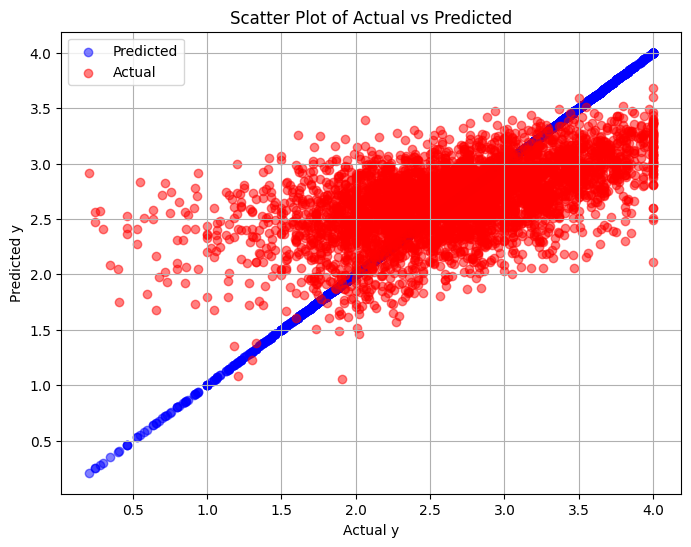

In [323]:
import matplotlib.pyplot as plt

numss = [np.random.randint(1,len(y)) for _ in range(500)]
y_rand = y[numss]
y_pred_rand = y_pred_all_unnormalized[numss]

# Assuming y_pred_all_unnormalized and y are numpy arrays of the same length
plt.figure(figsize=(8, 6))
plt.scatter(y, y, color='blue', label='Predicted', alpha=0.5)
plt.scatter(y, y_pred_all_unnormalized, color='red', label='Actual', alpha=0.5)  # Actual values
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Scatter Plot of Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()


In [324]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
best_model = 0
best_mse = 10

# Normalization
mean_X_train = np.mean(X_train, axis=0)
std_X_train = np.std(X_train, axis=0)
mean_y_train = np.mean(y_train)
std_y_train = np.std(y_train)


X_train_norm = (X_train - mean_X_train)/std_X_train
X_test_norm = (X_test - mean_X_train)/std_X_train


y_train_norm = (y_train - mean_y_train)/std_y_train
y_test_norm = (y_test - mean_y_train)/std_y_train

degrees = [1,2,4,8]
alphas = [0.1,0.5,1,5,10]
for deg in degrees:

    # Polynomial Features
    poly = PolynomialFeatures(degree=deg, include_bias= True)  # You can adjust the degree as needed
    X_poly_train_norm = poly.fit_transform(X_train_norm)

    for alpha in alphas:
        model = Ridge(alpha=alpha)
        model.fit(X_poly_train_norm, y_train_norm)

        X_poly_test_norm = poly.fit_transform(X_test_norm)


        train_mse = mean_squared_error(y_train, (model.predict(X_poly_train_norm)*std_y_train)+mean_y_train)
        test_mse = mean_squared_error(y_test, (model.predict(X_poly_test_norm)*std_y_train)+mean_y_train)
        
        if (test_mse < best_mse):
            best_mse = test_mse
            best_model = model
            best_poly = poly

c:\Users\moham\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.31721e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\moham\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.56361e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\moham\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.96139e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


The r2 score is:  0.3173625013027692


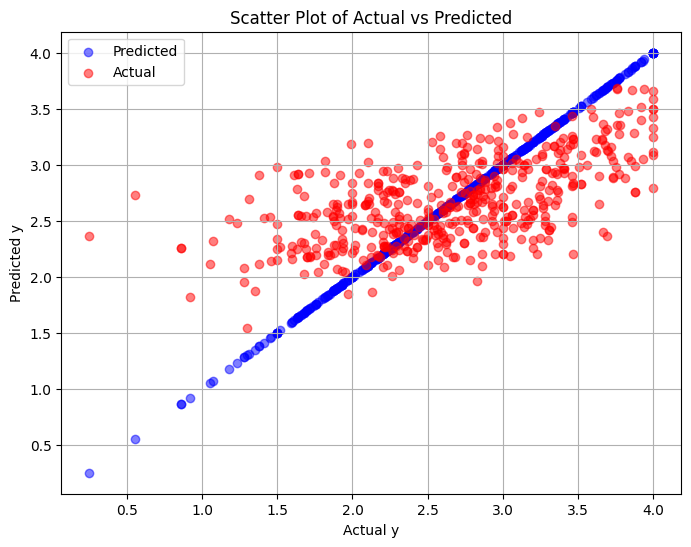

The r2 score is:  0.3173625013027692


In [325]:
X_norm = (X - mean_X_train)/std_X_train
X_poly = best_poly.fit_transform(X_norm)
y_pred_all_unnormalized = (best_model.predict(X_poly)*std_y_train)+mean_y_train

print ("The r2 score is: ", r2_score(y,y_pred_all_unnormalized))

numss = [np.random.randint(1,len(y)) for _ in range(500)]
y_rand = y[numss]
y_pred_rand = y_pred_all_unnormalized[numss]

# Assuming y_pred_all_unnormalized and y are numpy arrays of the same length
plt.figure(figsize=(8, 6))
plt.scatter(y_rand, y_rand, color='blue', label='Predicted', alpha=0.5)
plt.scatter(y_rand, y_pred_rand, color='red', label='Actual', alpha=0.5)  # Actual values
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Scatter Plot of Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()
print ("The r2 score is: ", r2_score(y,y_pred_all_unnormalized))


REMOVING OUTLIERS

In [326]:
change = 25

first_quartile = np.percentile(y, change)
fourth_quartile = np.percentile(y, 100-change)

iqr = fourth_quartile - first_quartile

lower_bound = first_quartile - 1.5 * iqr
upper_bound = fourth_quartile + 1.5 * iqr

outlier_indices = np.where((y < lower_bound) | (y > upper_bound))[0]

merged_df_no_OUT = merged_df[(merged_df['gpa'] > lower_bound) & (merged_df['gpa'] < upper_bound)]


X_no_outliers = merged_df_no_OUT[['SAT', 'athlete','hsize','hsrank','hsperc','female']]
y_no_outliers = merged_df_no_OUT['gpa']


In [327]:
best_mse = 10
best_model = 0


kf = KFold(n_splits=3, random_state=None)
total_test_mse = 0
total_train_mse = 0
    
for j, (train_index, test_index) in enumerate(kf.split(X_no_outliers)):

    # Train Test split
    X_train, X_test = X_no_outliers.iloc[train_index], X_no_outliers.iloc[test_index]
    y_train, y_test = y_no_outliers.iloc[train_index], y_no_outliers.iloc[test_index]


    # Normalization
    mean_X_train = np.mean(X_train, axis=0)
    std_X_train = np.std(X_train, axis=0)
    mean_y_train = np.mean(y_train)
    std_y_train = np.std(y_train)


    X_train_norm = (X_train - mean_X_train)/std_X_train
    X_test_norm = (X_test - mean_X_train)/std_X_train

    y_train_norm = (y_train - mean_y_train)/std_y_train
    y_test_norm = (y_test - mean_y_train)/std_y_train

    # Linear Regression
    model = LinearRegression()
    model.fit(X_train_norm, y_train_norm)

    # Train and test MSE
    y_train_predict_unnormalized = (model.predict(X_train_norm) * std_y_train) + mean_y_train
    y_test_predict_unnormalized = (model.predict(X_test_norm) * std_y_train) + mean_y_train

    train_mse = np.mean((y_train_predict_unnormalized - y_train) ** 2)
    test_mse = np.mean((y_test_predict_unnormalized - y_test) ** 2)
    total_train_mse += train_mse
    total_test_mse += test_mse

    if (test_mse < best_mse):
        best_mse = test_mse
        best_model = model

print("Average Train MSE:", total_train_mse / kf.get_n_splits())
print("Average Test MSE:", total_test_mse / kf.get_n_splits())


Average Train MSE: 0.27877940945899554
Average Test MSE: 0.28450351293256176


In [328]:
X_all_norm = (X_no_outliers - mean_X_train)/std_X_train
y_pred_all = best_model.predict(X_all_norm)
y_pred_all_unnormalized = (y_pred_all * std_y_train) + mean_y_train

print ("The r2 score is: ", r2_score(y_no_outliers,y_pred_all_unnormalized))

The r2 score is:  0.2980319065951216


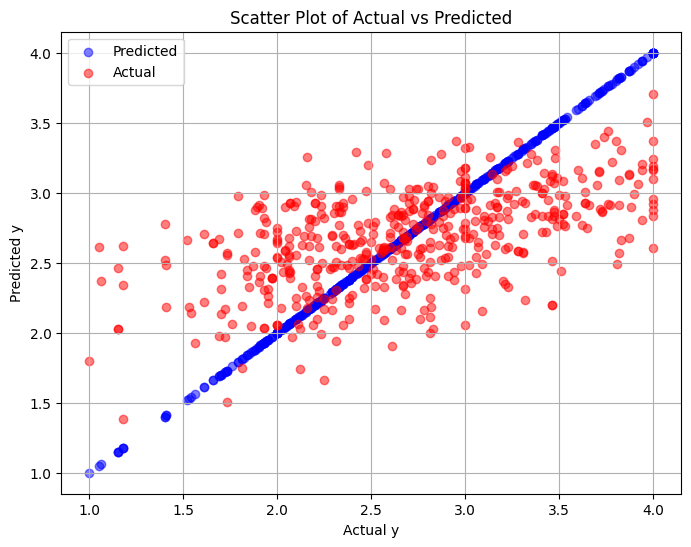

In [329]:
numss = [np.random.randint(1,len(y_no_outliers)) for _ in range(500)]
y_rand = y_no_outliers.iloc[numss]
y_pred_rand = y_pred_all_unnormalized[numss]

# Assuming y_pred_all_unnormalized and y are numpy arrays of the same length
plt.figure(figsize=(8, 6))
plt.scatter(y_rand, y_rand, color='blue', label='Predicted', alpha=0.5)
plt.scatter(y_rand, y_pred_rand, color='red', label='Actual', alpha=0.5)  # Actual values
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Scatter Plot of Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

In [330]:
X_train, X_test, y_train, y_test = train_test_split(X_no_outliers, y_no_outliers, test_size=0.2, random_state=50)
best_model = 0
best_mse = 10

# Normalization
mean_X_train = np.mean(X_train, axis=0)
std_X_train = np.std(X_train, axis=0)
mean_y_train = np.mean(y_train)
std_y_train = np.std(y_train)


X_train_norm = (X_train - mean_X_train)/std_X_train
X_test_norm = (X_test - mean_X_train)/std_X_train


y_train_norm = (y_train - mean_y_train)/std_y_train
y_test_norm = (y_test - mean_y_train)/std_y_train

degrees = [1,2,4,8]
alphas = [0.1,0.5,1,5,10]
for deg in degrees:

    # Polynomial Features
    poly = PolynomialFeatures(degree=deg, include_bias= True)  # You can adjust the degree as needed
    X_poly_train_norm = poly.fit_transform(X_train_norm)

    for alpha in alphas:
        model = Ridge(alpha=alpha)
        model.fit(X_poly_train_norm, y_train_norm)

        X_poly_test_norm = poly.fit_transform(X_test_norm)


        train_mse = mean_squared_error(y_train, (model.predict(X_poly_train_norm)*std_y_train)+mean_y_train)
        test_mse = mean_squared_error(y_test, (model.predict(X_poly_test_norm)*std_y_train)+mean_y_train)
        
        if (test_mse < best_mse):
            best_mse = test_mse
            best_model = model
            best_poly = poly

c:\Users\moham\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.21214e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\moham\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.55497e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\moham\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.47388e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [331]:
X_norm = (X_no_outliers - mean_X_train)/std_X_train
X_poly = best_poly.fit_transform(X_norm)
y_pred_all_unnormalized = (best_model.predict(X_poly)*std_y_train)+mean_y_train

print ("The r2 score is: ", r2_score(y_no_outliers,y_pred_all_unnormalized))


The r2 score is:  0.32129608769007334


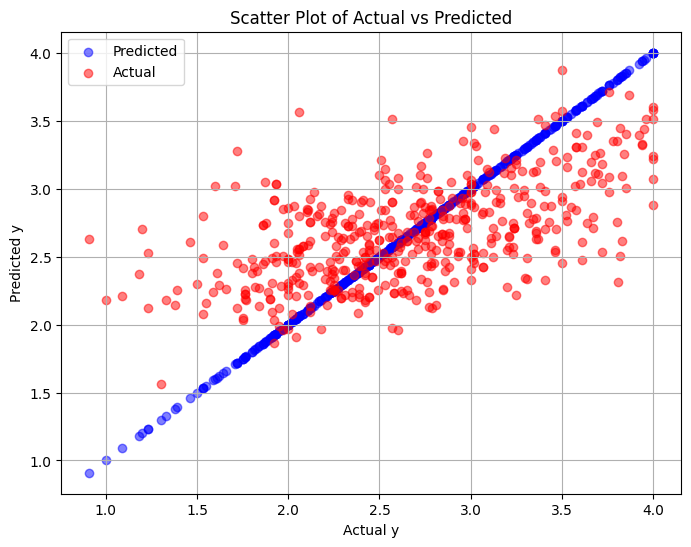

In [332]:
numss = [np.random.randint(1,len(y_no_outliers)) for _ in range(500)]
y_rand = y_no_outliers.iloc[numss]
y_pred_rand = y_pred_all_unnormalized[numss]

# Assuming y_pred_all_unnormalized and y are numpy arrays of the same length
plt.figure(figsize=(8, 6))
plt.scatter(y_rand, y_rand, color='blue', label='Predicted', alpha=0.5)
plt.scatter(y_rand, y_pred_rand, color='red', label='Actual', alpha=0.5)  # Actual values
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Scatter Plot of Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

Following commented code got cleaned in the above.


In [333]:
""" XColumns = ['SAT', 'athlete','hsize','hsrank','hsperc','female']

# Split data
X = merged_df[['SAT', 'athlete','hsize','hsrank','hsperc','female']]
y = merged_df['gpa']


# Try a different random seed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

mean_X = np.mean(X_train, axis=0)
std_X = np.std(X_train, axis=0)
mean_y = np.mean(y_train)
std_y = np.std(y_train)
X_train_norm = (X_train - mean_X) / std_X
y_train_norm = (y_train - mean_y) / std_y """

" XColumns = ['SAT', 'athlete','hsize','hsrank','hsperc','female']\n\n# Split data\nX = merged_df[['SAT', 'athlete','hsize','hsrank','hsperc','female']]\ny = merged_df['gpa']\n\n\n# Try a different random seed\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)\n\nmean_X = np.mean(X_train, axis=0)\nstd_X = np.std(X_train, axis=0)\nmean_y = np.mean(y_train)\nstd_y = np.std(y_train)\nX_train_norm = (X_train - mean_X) / std_X\ny_train_norm = (y_train - mean_y) / std_y "

In [334]:
""" # Train model
model = LinearRegression()
model.fit(X_train_norm, y_train_norm)

listCoeff = model.coef_

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print("Cross-validation RMSE scores:", cv_rmse)
print("Mean CV RMSE:", np.mean(cv_rmse))

# Predict and evaluate
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred))) """


' # Train model\nmodel = LinearRegression()\nmodel.fit(X_train_norm, y_train_norm)\n\nlistCoeff = model.coef_\n\n# Cross-validation\ncv_scores = cross_val_score(model, X, y, cv=5, scoring=\'neg_mean_squared_error\')\ncv_rmse = np.sqrt(-cv_scores)\nprint("Cross-validation RMSE scores:", cv_rmse)\nprint("Mean CV RMSE:", np.mean(cv_rmse))\n\n# Predict and evaluate\ny_train_pred = model.predict(X_train)\ny_test_pred = model.predict(X_test)\n\nprint("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))\nprint("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred))) '

In [335]:
""" 
N = len(X)
p = len(X.columns) + 1  # plus one because LinearRegression adds an intercept term
X_with_intercept = np.empty(shape=(N, p), dtype=float)
X_with_intercept[:, 0] = 1
X_with_intercept[:, 1:p] = X.values
beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y.values
print(beta_hat)

y_hat = model.predict(X)
residuals = (y.values) - (y_hat)
residual_sum_of_squares = residuals.T @ residuals
sigma_squared_hat = residual_sum_of_squares / (N - p)
var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat
for p_ in range(p):
    standard_error = var_beta_hat[p_, p_] ** 0.5
    print(f"SE(beta_hat[{p_}]): {standard_error}")


print ("The r2 score is: ", r2_score(y,y_hat)) """

' \nN = len(X)\np = len(X.columns) + 1  # plus one because LinearRegression adds an intercept term\nX_with_intercept = np.empty(shape=(N, p), dtype=float)\nX_with_intercept[:, 0] = 1\nX_with_intercept[:, 1:p] = X.values\nbeta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y.values\nprint(beta_hat)\n\ny_hat = model.predict(X)\nresiduals = (y.values) - (y_hat)\nresidual_sum_of_squares = residuals.T @ residuals\nsigma_squared_hat = residual_sum_of_squares / (N - p)\nvar_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat\nfor p_ in range(p):\n    standard_error = var_beta_hat[p_, p_] ** 0.5\n    print(f"SE(beta_hat[{p_}]): {standard_error}")\n\n\nprint ("The r2 score is: ", r2_score(y,y_hat)) '

In [336]:
""" from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Split data
X = merged_df[['SAT', 'athlete','hsize','hsrank','hsperc','female']]
y = merged_df['gpa']  # Assuming 'gpa' is the continuous variable to predict

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Train model
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print("Cross-validation RMSE scores:", cv_rmse)
print("Mean CV RMSE:", np.mean(cv_rmse))

# Predict and evaluate
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
 """

' from sklearn.model_selection import train_test_split, cross_val_score\nfrom sklearn.tree import DecisionTreeRegressor\nfrom sklearn.metrics import mean_squared_error\nimport numpy as np\n\n# Split data\nX = merged_df[[\'SAT\', \'athlete\',\'hsize\',\'hsrank\',\'hsperc\',\'female\']]\ny = merged_df[\'gpa\']  # Assuming \'gpa\' is the continuous variable to predict\n\n# Train-test split\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)\n\n# Train model\nmodel = DecisionTreeRegressor()\nmodel.fit(X_train, y_train)\n\n# Cross-validation\ncv_scores = cross_val_score(model, X, y, cv=5, scoring=\'neg_mean_squared_error\')\ncv_rmse = np.sqrt(-cv_scores)\nprint("Cross-validation RMSE scores:", cv_rmse)\nprint("Mean CV RMSE:", np.mean(cv_rmse))\n\n# Predict and evaluate\ny_train_pred = model.predict(X_train)\ny_test_pred = model.predict(X_test)\n\nprint("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))\nprint("Test RMSE:", np.sqrt(mean

In [337]:
""" from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

# Split data
X = merged_df[['SAT', 'athlete','hsize','hsrank','hsperc','female']]
y = merged_df['gpa']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Train model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print("Cross-validation RMSE scores:", cv_rmse)
print("Mean CV RMSE:", np.mean(cv_rmse))

# Predict and evaluate
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
 """

' from sklearn.ensemble import RandomForestRegressor\nfrom sklearn.model_selection import cross_val_score\nfrom sklearn.metrics import mean_squared_error\nimport numpy as np\n\n# Split data\nX = merged_df[[\'SAT\', \'athlete\',\'hsize\',\'hsrank\',\'hsperc\',\'female\']]\ny = merged_df[\'gpa\']\n\n# Train-test split\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)\n\n# Train model\nmodel = RandomForestRegressor()\nmodel.fit(X_train, y_train)\n\n# Cross-validation\ncv_scores = cross_val_score(model, X, y, cv=5, scoring=\'neg_mean_squared_error\')\ncv_rmse = np.sqrt(-cv_scores)\nprint("Cross-validation RMSE scores:", cv_rmse)\nprint("Mean CV RMSE:", np.mean(cv_rmse))\n\n# Predict and evaluate\ny_train_pred = model.predict(X_train)\ny_test_pred = model.predict(X_test)\n\nprint("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))\nprint("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))\n '

In [338]:
""" from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

# Split data
X = merged_df[['SAT', 'athlete','hsize','hsrank','hsperc','female']]
y = merged_df['gpa']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Train model
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print("Cross-validation RMSE scores:", cv_rmse)
print("Mean CV RMSE:", np.mean(cv_rmse))

# Predict and evaluate
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
 """

' from sklearn.ensemble import GradientBoostingRegressor\nfrom sklearn.model_selection import cross_val_score\nfrom sklearn.metrics import mean_squared_error\nimport numpy as np\n\n# Split data\nX = merged_df[[\'SAT\', \'athlete\',\'hsize\',\'hsrank\',\'hsperc\',\'female\']]\ny = merged_df[\'gpa\']\n\n# Train-test split\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)\n\n# Train model\nmodel = GradientBoostingRegressor()\nmodel.fit(X_train, y_train)\n\n# Cross-validation\ncv_scores = cross_val_score(model, X, y, cv=5, scoring=\'neg_mean_squared_error\')\ncv_rmse = np.sqrt(-cv_scores)\nprint("Cross-validation RMSE scores:", cv_rmse)\nprint("Mean CV RMSE:", np.mean(cv_rmse))\n\n# Predict and evaluate\ny_train_pred = model.predict(X_train)\ny_test_pred = model.predict(X_test)\n\nprint("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))\nprint("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))\n '

HERE STARTS CLASSIFICATION CODE CLEANING


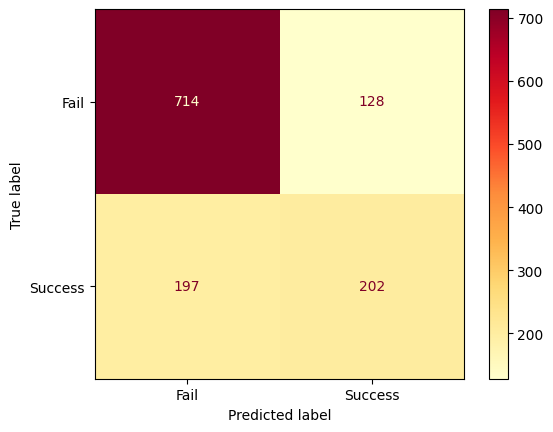

0.7381144238517324


In [339]:
X = merged_df[['SAT', 'athlete','hsize','hsrank','hsperc','female']]
y = merged_df['Success']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
model = KNeighborsClassifier(n_neighbors= 5)

#Normalization
mean_X_train = np.mean(X_train, axis=0)
std_X_train = np.std(X_train, axis=0)


X_train_norm = (X_train-mean_X_train)/std_X_train


model.fit(X_train_norm,y_train)

X_test_norm = (X_test - mean_X_train)/ std_X_train


y_pred = model.predict(X_test_norm)

cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Fail", "Success"],)
cm_display.plot(cmap = "YlOrRd")
plt.show()

print(model.score(X_test_norm, y_test))

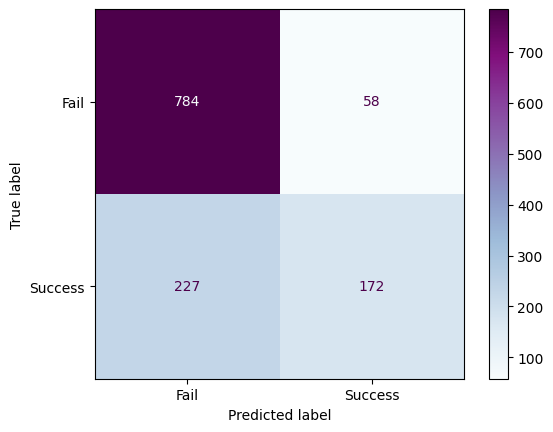

0.7703464947622884


In [340]:



model = LogisticRegression(random_state=0,C=0.01,fit_intercept=True)
model.fit(X_train_norm, y_train)

y_pred = model.predict(X_test_norm)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Fail", "Success"],)
cm_display.plot(cmap = "BuPu")
plt.show()

print(model.score(X_test_norm, y_test))

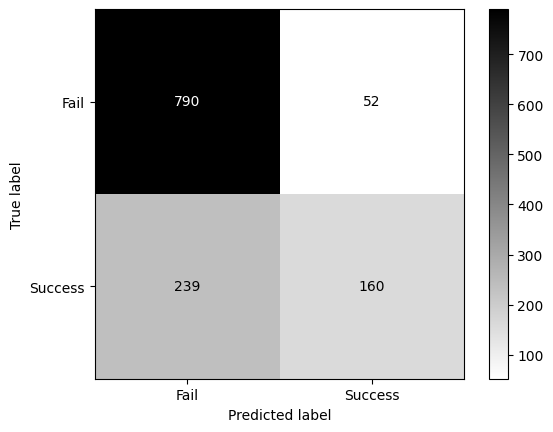

0.765511684125705


In [341]:


model = SVC(kernel='rbf', probability=True)
model.fit(X_train_norm, y_train)

y_pred = model.predict(X_test_norm)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Fail", "Success"],)
cm_display.plot(cmap = "binary")
plt.show()

print(model.score(X_test_norm, y_test))





1. Coorelation testing - Heatmaps, pair plots, hypothesis testing,  qq plot 
2. EDA
3. EDA models 
4. Report 

5 (Extra). Understand models extensively
